# Pkg Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Setting up  Environments 

In [17]:
sns.set(style='darkgrid', context='talk', palette='rainbow', font_scale=.75)
palette = sns.color_palette("rocket", n_colors=11)
sns.set_palette(palette)

### loading Dataset ...

In [18]:
dataset_url='https://archive.ics.uci.edu/static/public/165/data.csv'

dataframe = pd.read_csv(dataset_url)

dataframe.columns = [str(col).strip() for col in dataframe.columns]

dataframe.rename(columns={'Concrete compressive strength': 'Strength'}, inplace=True)

print(f'Dtaset Size {dataframe.shape}, Row count {dataframe.shape[0]} , feature count {dataframe.shape[1]}')

dataframe.head()

Dtaset Size (1030, 9), Row count 1030 , feature count 9


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### Null Analysis

In [19]:
dataframe.isna().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

### Duplicate Removal

In [20]:
dup_data = dataframe[dataframe.duplicated(keep='first')]
print(f'Duplicate Count {dup_data.shape[0]}')
if not dup_data.empty:
    dataframe.drop_duplicates(keep='first', inplace=True)
    dup_data = dataframe[dataframe.duplicated(keep='first')]
    print(f'Duplicate Count after Duplicate Remover {dup_data.shape[0]}')



Duplicate Count 25
Duplicate Count after Duplicate Remover 0


### Outlier Removal


In [22]:
target_col = 'Strength'
outlier_thre = 75
dataframe = dataframe[dataframe[target_col]< outlier_thre]

print(f'Dtaset Size {dataframe.shape}, Row count {dataframe.shape[0]} , feature count {dataframe.shape[1]}')


Dtaset Size (994, 9), Row count 994 , feature count 9


### Target Column seperation

In [23]:
data_x = dataframe.copy(deep=True)
data_y = data_x.pop(target_col)

print(f'data_x Size {data_x.shape}, Row count {data_x.shape[0]} , feature count {data_x.shape[1]}')

print(f'data_y Size {data_y.shape}')


data_x Size (994, 8), Row count 994 , feature count 8
data_y Size (994,)


### Modeling ....

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


models = [
    ('SVR', SVR(kernel='linear')),
    ('LINEAR', LinearRegression(n_jobs=-1)),
    ('RIDGE', Ridge(random_state=43)),
    ('LASSO', Lasso(random_state=43)),
    ('POLY_REG', Pipeline([
                            ('PolyFeat', PolynomialFeatures(degree=3).set_output(transform="pandas")),
                            ('estimator', LinearRegression(n_jobs=-1))
                            ])
    ),
    ('KNN', KNeighborsRegressor(n_jobs=-1)),
    ('DECISION_TREE', DecisionTreeRegressor(random_state=43)),
    ('EXTRA_TREE', ExtraTreeRegressor(random_state=43)),
    ('RANDOM_FOREST', RandomForestRegressor(random_state=43,n_jobs=-1 )),
    ('EX_TREE_ENSEMBLE', ExtraTreesRegressor(random_state=43,n_jobs=-1)),
    ('GB_TREE_ENSEMBLE', GradientBoostingRegressor(random_state=43))
    ]
artifacts = []
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']


In [25]:
from dataclasses import dataclass, field
from typing import Any,Dict, List

@dataclass
class Artifact:
    
    name: str
    model: Any
    cv_results: Dict[str, List[float]] = field(default_factory=dict)
        
    
    @property
    def mae(self) -> float:
        test_neg_mae = self.cv_results.get('test_neg_mean_absolute_error', [0])
        return -1 * np.average(test_neg_mae)
    
    @property
    def mse(self)-> float:
        test_neg_mse = self.cv_results.get('test_neg_mean_squared_error', [0])
        return -1 * np.average(test_neg_mse)
    
    @property
    def rmse(self)-> float:
        test_neg_rmse = self.cv_results.get('test_neg_root_mean_squared_error', [0])
        return -1 * np.average(test_neg_rmse)
    
    @property
    def r2(self)-> float:
        test_r2 = self.cv_results.get('test_r2', [0])
        return np.average(test_r2)
    
    @property
    def as_dataframe(self):
        df = pd.DataFrame(self.cv_results)
        df['model'] = self.name
        return df


In [26]:
from sklearn.model_selection import KFold, cross_validate

kfold = KFold(n_splits=5, shuffle=True, random_state=90210)

        
for name_t, model_t in models:
    cv_results_t = cross_validate(model_t, 
                                  data_x, 
                                  data_y, 
                                  cv=kfold, 
                                  scoring=scoring, 
                                  n_jobs=-1, 
                                  return_estimator =True, 
                                  verbose=1)
    artifacts.append(Artifact(name=name_t,model=model_t,cv_results=cv_results_t))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out

In [27]:
artifacts[0].cv_results

{'fit_time': array([4.90012026, 5.17378592, 5.35315967, 5.94765854, 5.06233168]),
 'score_time': array([0.        , 0.01552963, 0.        , 0.        , 0.        ]),
 'estimator': [SVR(kernel='linear'),
  SVR(kernel='linear'),
  SVR(kernel='linear'),
  SVR(kernel='linear'),
  SVR(kernel='linear')],
 'test_neg_mean_absolute_error': array([-7.73380235, -7.82224637, -8.77970877, -7.67456233, -8.41223508]),
 'test_neg_mean_squared_error': array([-112.70546275, -102.67699848, -138.80211208,  -98.14636272,
        -113.93079075]),
 'test_neg_root_mean_squared_error': array([-10.61628291, -10.13296593, -11.78143082,  -9.90688461,
        -10.67383674]),
 'test_r2': array([0.45495968, 0.64159924, 0.49171078, 0.56950469, 0.50753669])}

In [28]:
result_df= pd.DataFrame()
for item in artifacts:
    result_df = pd.concat([result_df, item.as_dataframe])
    
result_df['test_mean_squared_error'] = -1*result_df['test_neg_mean_squared_error']
result_df['test_mean_absolute_error'] = -1*result_df['test_neg_mean_absolute_error']
result_df['test_root_mean_squared_error'] = -1*result_df['test_neg_root_mean_squared_error']

result_df.drop(columns=['test_neg_mean_squared_error',
                        'test_neg_mean_absolute_error',
                        'test_neg_root_mean_squared_error'], inplace=True)

result_df.head()

,fit_time,score_time,estimator,test_r2,model,test_mean_squared_error,test_mean_absolute_error,test_root_mean_squared_error
0,4.900120,0.00000,SVR(kernel='linear'),0.454960,SVR,112.705463,7.733802,10.616283
1,5.173786,0.01553,SVR(kernel='linear'),0.641599,SVR,102.676998,7.822246,10.132966
2,5.353160,0.00000,SVR(kernel='linear'),0.491711,SVR,138.802112,8.779709,11.781431
3,5.947659,0.00000,SVR(kernel='linear'),0.569505,SVR,98.146363,7.674562,9.906885
4,5.062332,0.00000,SVR(kernel='linear'),0.507537,SVR,113.930791,8.412235,10.673837


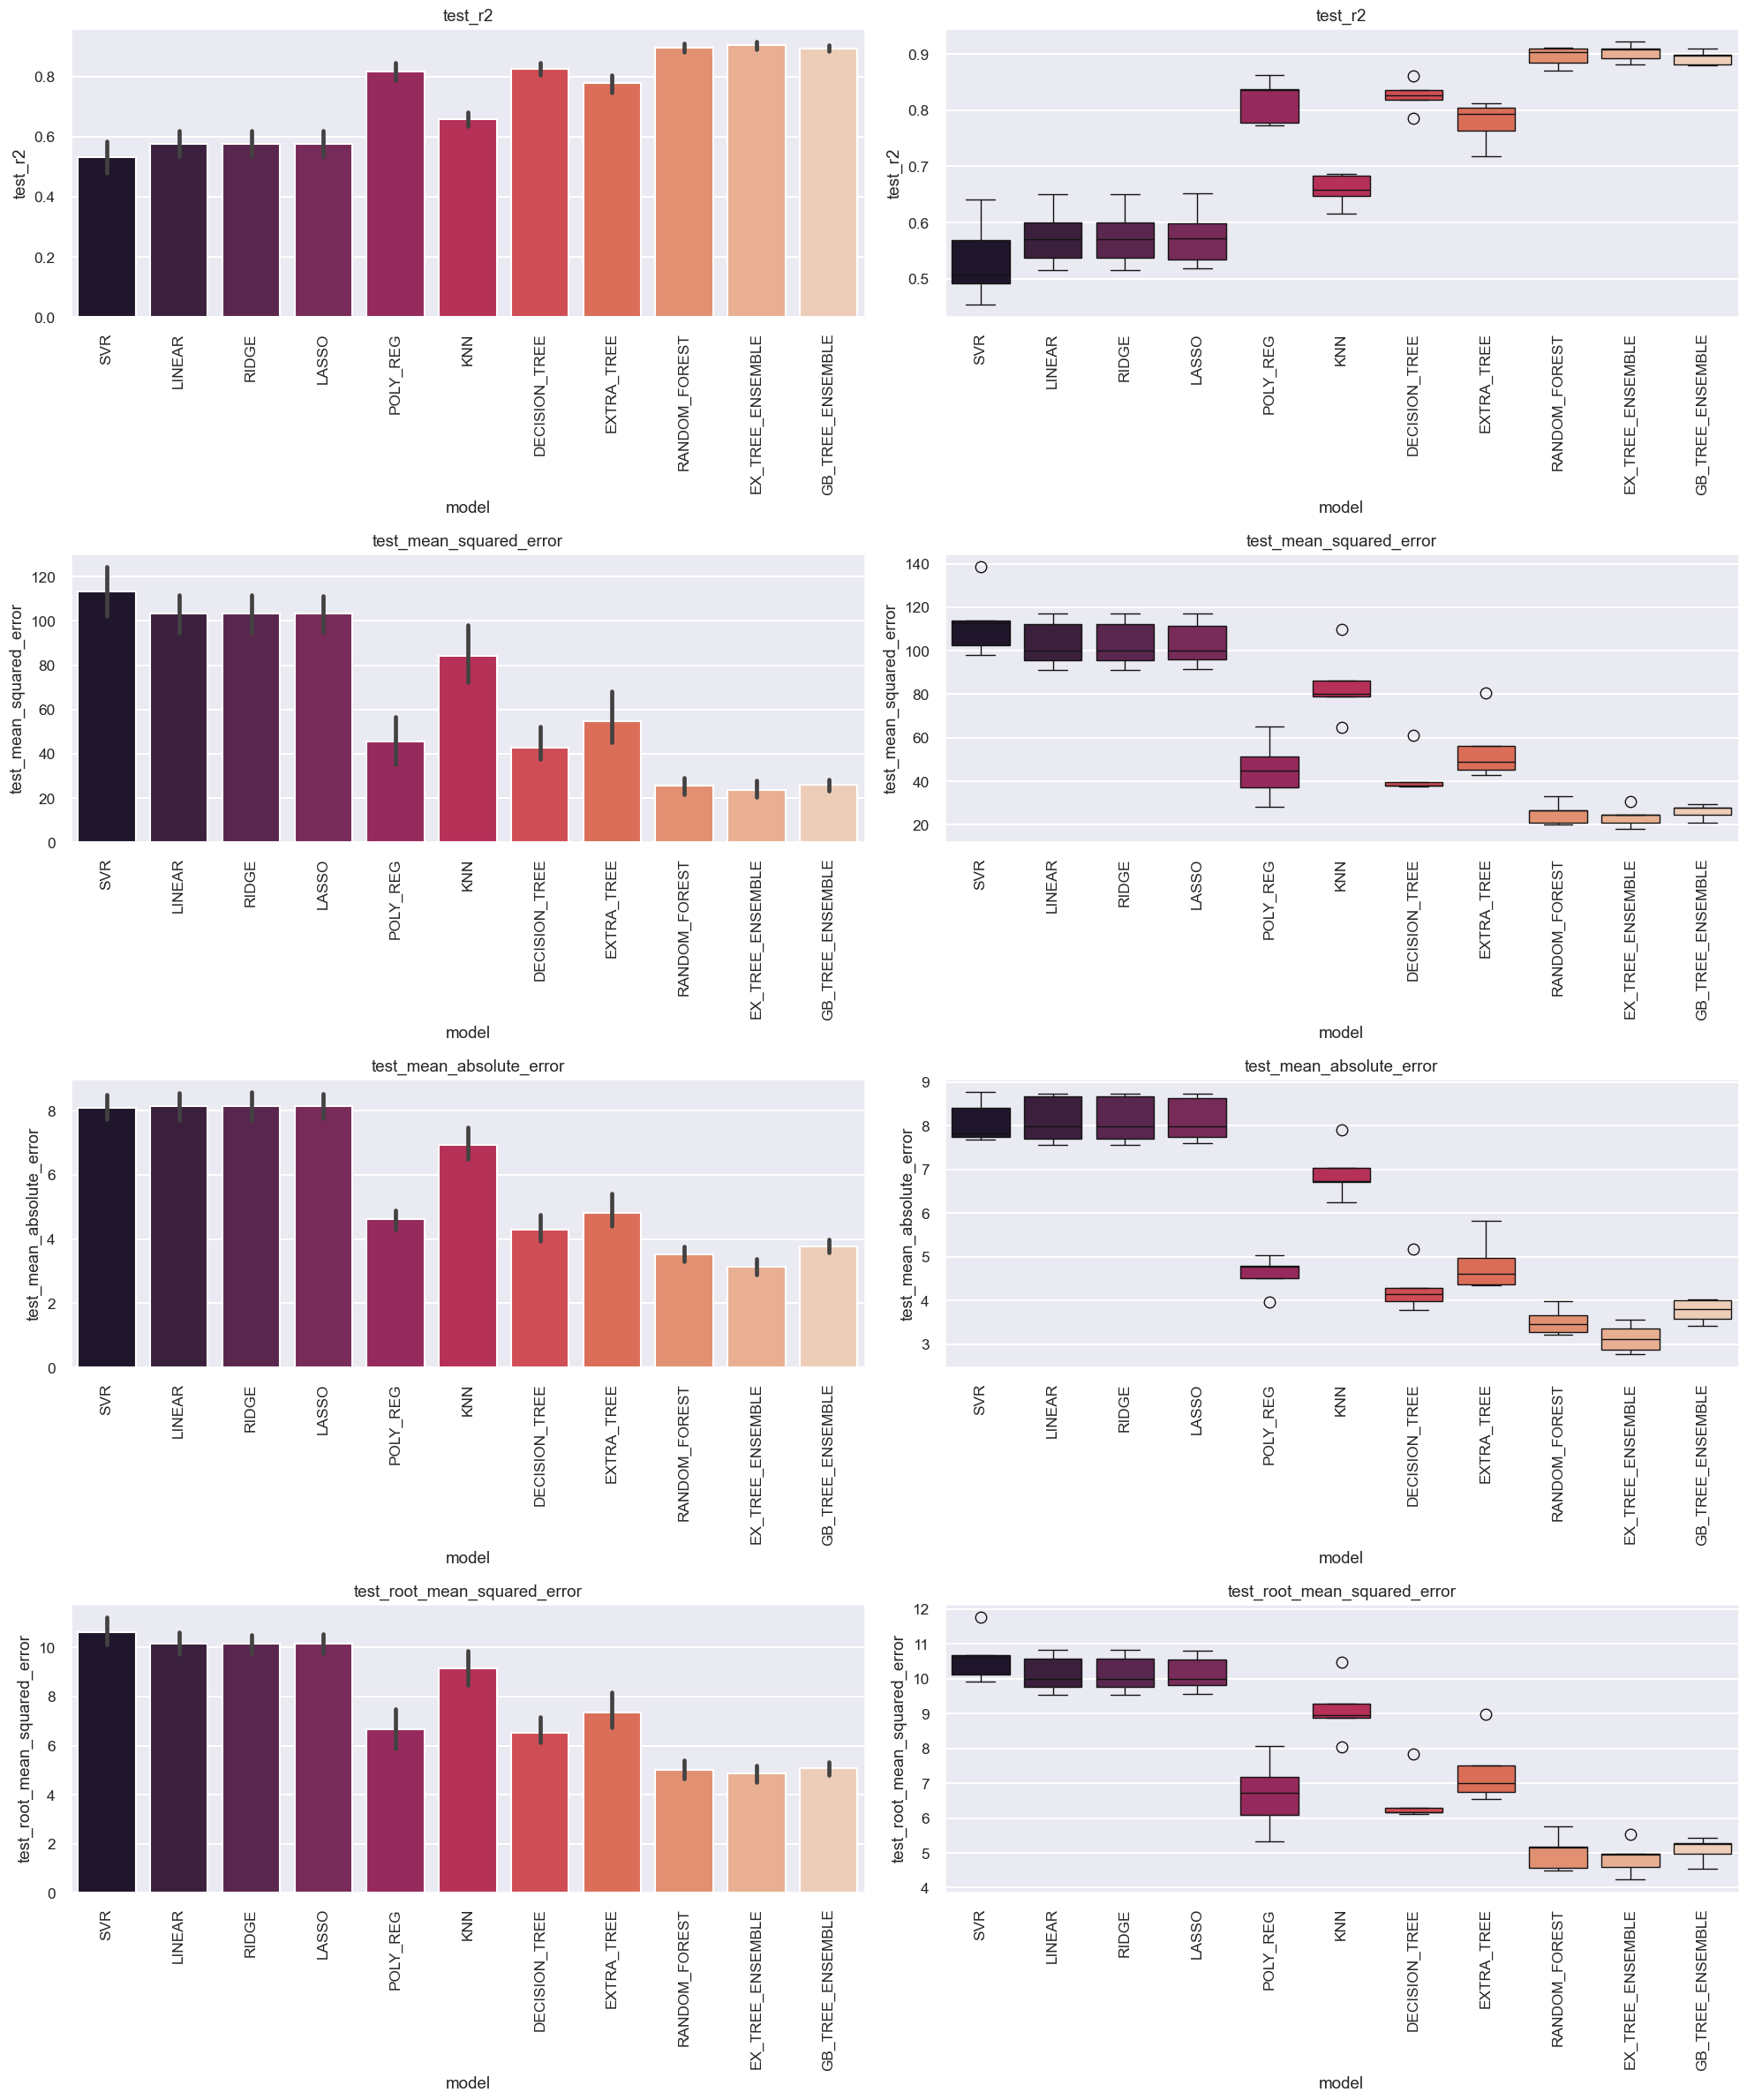

In [29]:
scores_data = len(scoring)
fig, axes = plt.subplots(nrows=scores_data, ncols=2, figsize=(20, 6*scores_data))

col_idx = 0
for _, column in enumerate(result_df.columns):
    if 'test_' not in column:
        continue

    sns.barplot(y = column, x='model', data=result_df, hue='model',palette=palette, ax=axes[col_idx][0])
    axes[col_idx][0].set_title(column)
    axes[col_idx][0].tick_params(axis="x", rotation=90)

    sns.boxplot(y = column, x='model', data=result_df, hue='model',palette=palette, ax=axes[col_idx][1])
    axes[col_idx][1].set_title(column)
    axes[col_idx][1].tick_params(axis="x", rotation=90)

    col_idx+=1
plt.tight_layout()
plt.show()



## Feature Importance 

### Linear Model

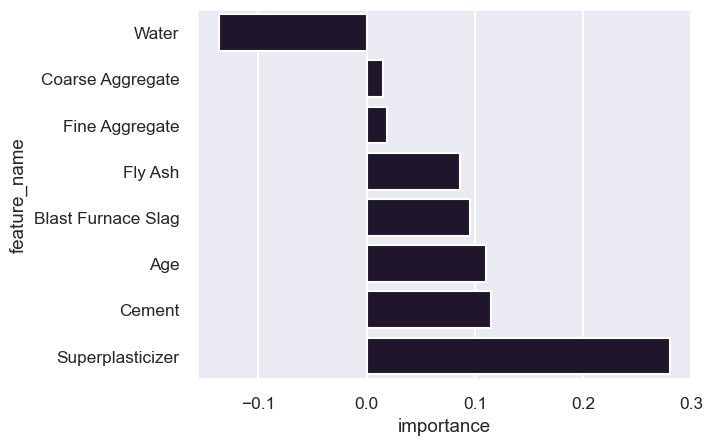

In [32]:
### Linear Model
model = LinearRegression()
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.coef_, "feature_name":model.feature_names_in_})
forest_importances.sort_values(by='importance', inplace=True)

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)

### Ridge

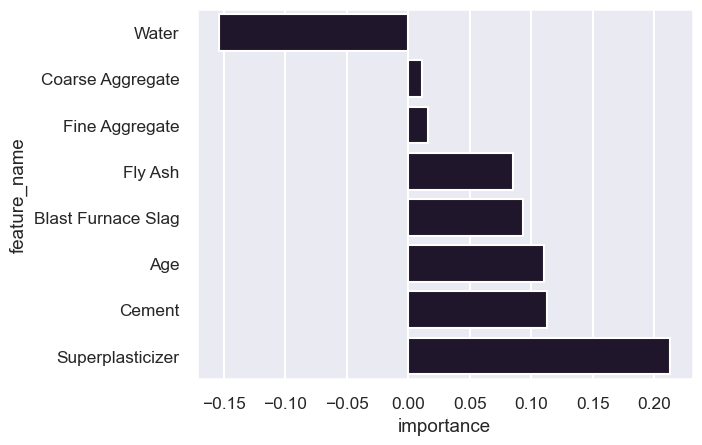

In [31]:
### Linear Model
model = Lasso(random_state=43)
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.coef_, "feature_name":model.feature_names_in_})

forest_importances.sort_values(by='importance', inplace=True)

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)

### Lasso

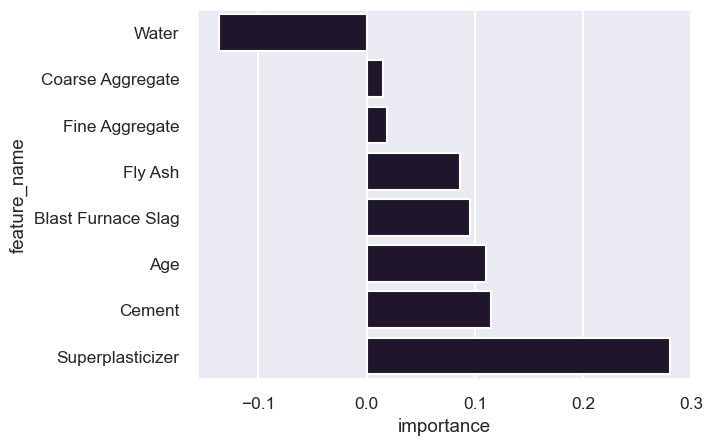

In [33]:
### Linear Model
model = Ridge(random_state=43)
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.coef_, "feature_name":model.feature_names_in_})
forest_importances.sort_values(by='importance', inplace=True)

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)

### Polynominal Regression

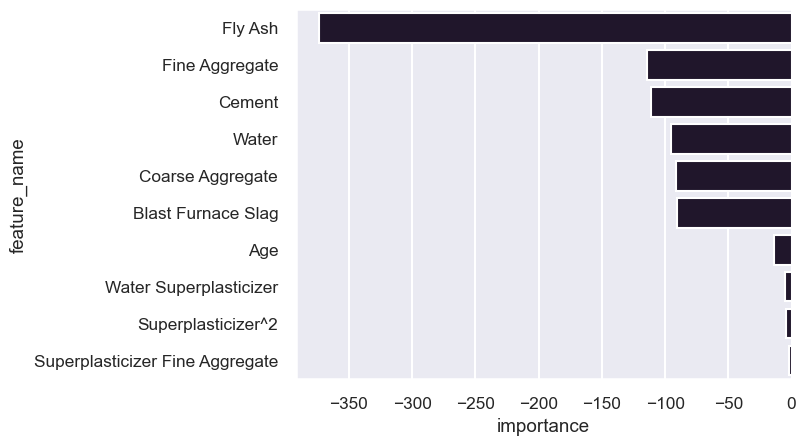

In [36]:

model = Pipeline([
('PolyFeat', PolynomialFeatures(degree=3).set_output(transform="pandas")),
('estimator', LinearRegression(n_jobs=-1))
])
model.fit(data_x,data_y)

model_ = model.named_steps['estimator']

forest_importances = pd.DataFrame({'importance':model_.coef_, "feature_name":model_.feature_names_in_})

forest_importances.sort_values(by='importance', inplace=True)

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances.head(10))

del model

### Decession Tree

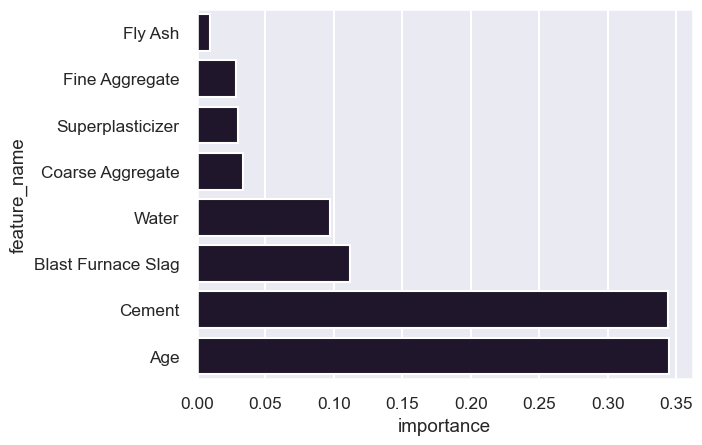

In [37]:
### Linear Model
model = DecisionTreeRegressor(random_state=43)
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.feature_importances_, "feature_name":model.feature_names_in_})
forest_importances.sort_values(by='importance', inplace=True)

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)

### Random Forest

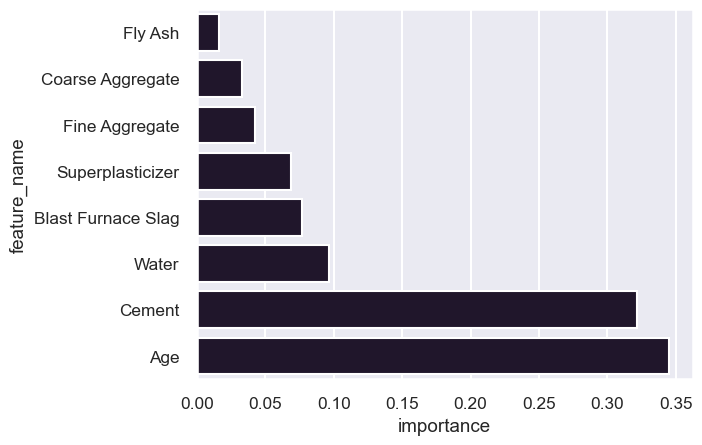

In [38]:
### Linear Model
model = RandomForestRegressor(random_state=43)
model.fit(data_x,data_y)

forest_importances = pd.DataFrame({'importance':model.feature_importances_, "feature_name":model.feature_names_in_})
forest_importances.sort_values(by='importance', inplace=True)

_ = sns.barplot(x='importance', y='feature_name', data=forest_importances)